# Airports in Scotland

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import list of nodes
airports = pd.read_csv("ListOfAirportsAndAirfields.csv")
airports.head()

,id,airport,latitude,longitude
0,0,Aberdeen International Airport,57.2037,-2.2005
1,1,Edinburgh Airport,55.9474,-3.3614
2,2,Glasgow Airport,55.8699,-4.4326
3,3,Glasgow Prestwick Airport,55.5112,-4.5911
4,4,Oban Airport,56.4655,-5.3983


In [2]:
# import list of edges
edges = pd.read_csv("FlightRoutes.csv")
edges.head()

,departure,destination
0,0,11
1,0,13
2,0,15
3,1,13
4,1,12


## Data cleaning and formatting

In [3]:
airports.dtypes

id             int64
airport       object
latitude     float64
longitude    float64
dtype: object

Let's make sure the airports are stored as categorical data.

In [4]:
airports["airport"] = airports["airport"].astype("category")

In [5]:
# data on Oban to Coll and Colonsay is missing from the dataset
edges.dtypes
# Do departure and destination need to be categories or integers?

departure      int64
destination    int64
dtype: object

Now let's replace all the numerical identifiers with the names of the airports in our edges list.

In [6]:
for edge in edges:
    print(edge)
"""
    # get id of departure and destination
    dep = edge["departure"]
    arr = edge["destination"]

    # get name of departure and destination
    depName = airports[airports.id == dep].airport
    arrName = airports[airports.id == arr].airport

    # replace id with name
    edges[edge]["departure"] = depName
    edges[edge]["destination"] = arrName
"""

edges.head()

departure
destination


,departure,destination
0,0,11
1,0,13
2,0,15
3,1,13
4,1,12


## Create Network

In [7]:
# create graph
G = nx.Graph()
for i, node in airports.iterrows():
    G.add_node(node["airport"], pos=(node["latitude"], node["longitude"]))

# add edges to graph
all_edges = {}
for i, edge in edges.iterrows():
    G.add_edge(edge["departure"], edge["destination"])
    #all_edges[(edge["departure"], edge["destination"])] = edge["departure"]+"<-->"+edge["destination"]

## Generate Network Map

NetworkXError: Node 0 has no position.

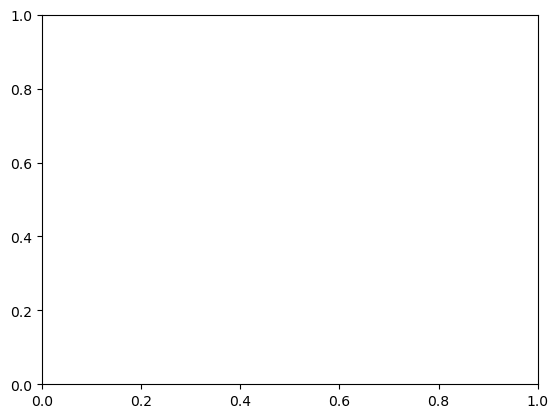

In [8]:
# draw the network
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="blue", alpha=1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color="black", width=2, arrows=True)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=all_edges, font_color="black")

## Plot against a map of Scotland

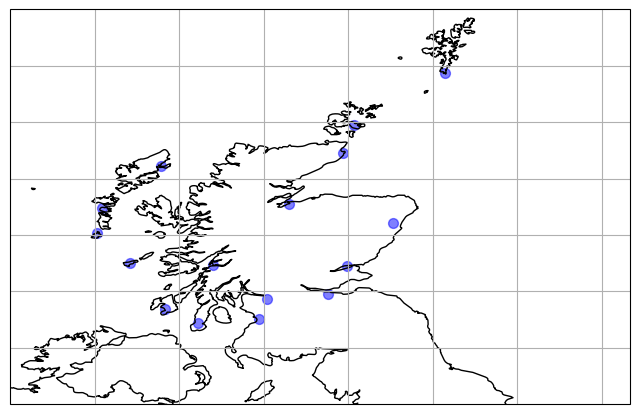

In [20]:
mapProjection = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=mapProjection)
ax.set_extent([-9, 2, 54, 61], crs=ccrs.PlateCarree())
#ax.set_global()
ax.add_feature(cfeature.COASTLINE, edgecolor="black")
ax.add_feature(cfeature.BORDERS, edgecolor="black")
ax.gridlines()

ax.scatter(x=airports.longitude, y=airports.latitude, color="blue", s=50, alpha=0.5, transform=ccrs.PlateCarree())